# Distal Events Table

__Description__: Excess rainfall is calculated using updated randomized curve numbers and the original precipitation events calculated in `EventsTable.ipynb`. The events are then combined using the groups determined from the convolution steps in `EventsTable.ipynb`.
    
__Input__: 
- The pluvial_parameters.xlsx which contains the distal domains and their corresponding curve numbers.
- The metadata *.json* file from PM-EventsTable.ipynb, which contains the final precipitation curves for each randomized event.
- The weights *.json* file from PM-EventsTable.ipynb, which contains the weight for each randomized event.


__Output__:
- The incremental excess rainfall for a suite of events at each duration and boundary condition.
- The metadata associated with each event, including the randomized precipitation data, curve numbers, and the underlying events that were grouped to create the final set of events. 
    
---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
import hydromet_distal
from hydromet import*

### Parameters:

#### Site specific:

In [2]:
## Filenames and paths:
Project_Area = 'Test'  # Project area name
Pluvial_Model = 'P01'  # Pluvial model name
mainBCN = 'D01'        # Domain/boundary condition name
  
pluvial_params = '{0}_{1}_Pluvial_Parameters.xlsx'.format(Project_Area, Pluvial_Model)
rate_column = 'SW Rate (in/30min)'
capacity_column = 'SW Capacity (in)'
efficiency_column = 'SW Efficiency'

root_dir = pl.Path(os.getcwd())
inputs_dir = root_dir/'Inputs'
outputs_dir = root_dir/'Outputs'
notebook_dir = root_dir/'Notebooks'
pluvial_params_dir = inputs_dir/pluvial_params
datarepository_dir = root_dir/'DataRepository'


## Options:
display_plots = True  # Option to display plots
display_print = True  # Option to display print statements

#### Global (project specific):

In [3]:
## Filenames and paths:
CN_Distribution = 'NEH630_Table_10_1.json'


## Options:
adjust_CN_less24 = False                           # Set to True to adjust the curve number when the storm duration is less than 24 hours
remove_intermediates = True
run_dur_dic = {'6': 1, '12': 1, '24': 2, '96': 5}  # Run durations in days

pad_forcing = True  # Specify whether to pad the forcing time series
uniform_pad = True  # Uniform padding of length pad_num if True. If False, the number of zeros padded is determined by the run duration
pad_num = 2         # Number of zeros to pad to the forcing time series

start_time = time.time()

###  Data:
#### MainBCN Forcing:

In [4]:
with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, mainBCN)) as f:
    main = json.load(f)

##### Check for padding:

In [5]:
if pad_forcing:
    check_pluvial_padding(main, display_print)

Time index and first pluvial domain are padded


##### Extract the durations:

In [6]:
durations = list(main.keys())
print('Durations:', durations)

Durations: ['H06', 'H12', 'H24', 'H96']


##### Extract the time index ordinate:

In [7]:
time_idx_ordinate = main[durations[0]]['time_idx_ordinate']
print('Time index ordinate:', time_idx_ordinate)

Time index ordinate: Hours


##### Extract the pluvial boundary condition units:

In [8]:
pluvial_BC_units = main[durations[0]]['pluvial_BC_units']
print('Pluvial boundary condition units:', pluvial_BC_units)

Pluvial boundary condition units: inch/ts


#### Metadata:

In [9]:
with open(outputs_dir/'{0}_{1}_{2}_Metadata.json'.format(Project_Area, Pluvial_Model, mainBCN)) as f:
    md = json.load(f)

#### Event weights:

In [10]:
with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Pluvial_Model, mainBCN)) as f:
    weights_dic =  json.load(f)

#### Pluvial domain information:

In [11]:
pp = pd.read_excel(pluvial_params_dir, sheet_name = 'Pluvial_Domain')
pp.head(2)

,Pluvial Domain,Shapefile,Curve Number,SW Infrastructure (YES or NO),SW Rate (in/30min),SW Capacity (in),SW Efficiency,Comments
0,D01,Test_P01.shp,83.7,YES,0.62,8.38,0.75,Main domain
1,D02,Test_P01.shp,88.8,YES,1.63,8.38,0.75,NaN


##### Extract the distal domains:

In [12]:
distalBCNs = list(pp['Pluvial Domain'])
distalBCNs.remove(mainBCN)
print('All distal domains/boundary condition names:', distalBCNs)

All distal domains/boundary condition names: ['D02']


---

## B. Calculate Excess Rainfall and Group Events:
- For each distal domain:
    - Extract the curve number from the Pluvial Parameters file.
    - Get the curve number distribution
    - Extract the data from the metadata dictionary.
    - Calculate random curve numbers.
    - Perform the excess rainfall calculation.
    - Combine the events using the previously determined groups.
    - Save the excess rainfall and metadata.
    - Plot the results.

,Pluvial Domain,Shapefile,Curve Number,SW Infrastructure (YES or NO),SW Rate (in/30min),SW Capacity (in),SW Efficiency,Comments
1,D02,Test_P01.shp,88.8,YES,1.63,8.38,0.75,NaN


None
{'Dry': 76, 'Wet': 96}
Calculating excess rainfall and grouping the 6 hour duration for D02
Calculating excess rainfall and grouping the 12 hour duration for D02
Calculating excess rainfall and grouping the 24 hour duration for D02
Calculating excess rainfall and grouping the 96 hour duration for D02


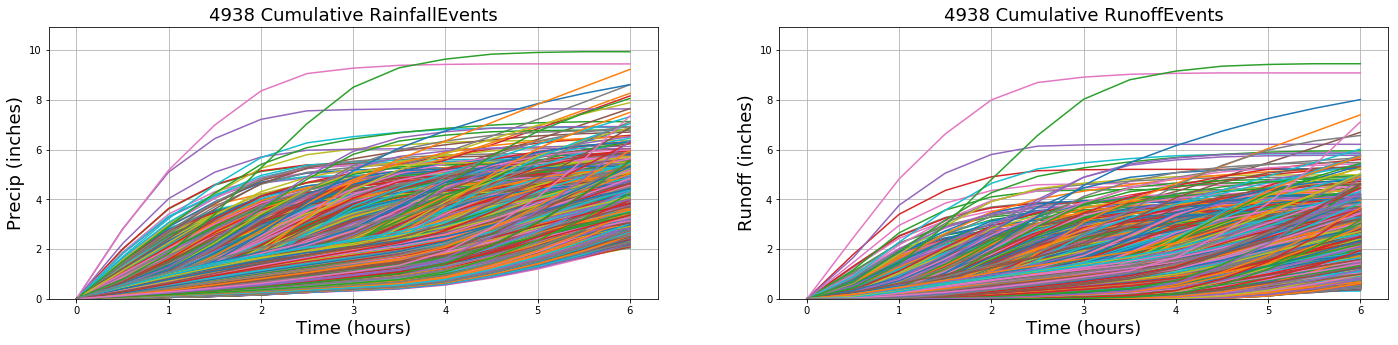

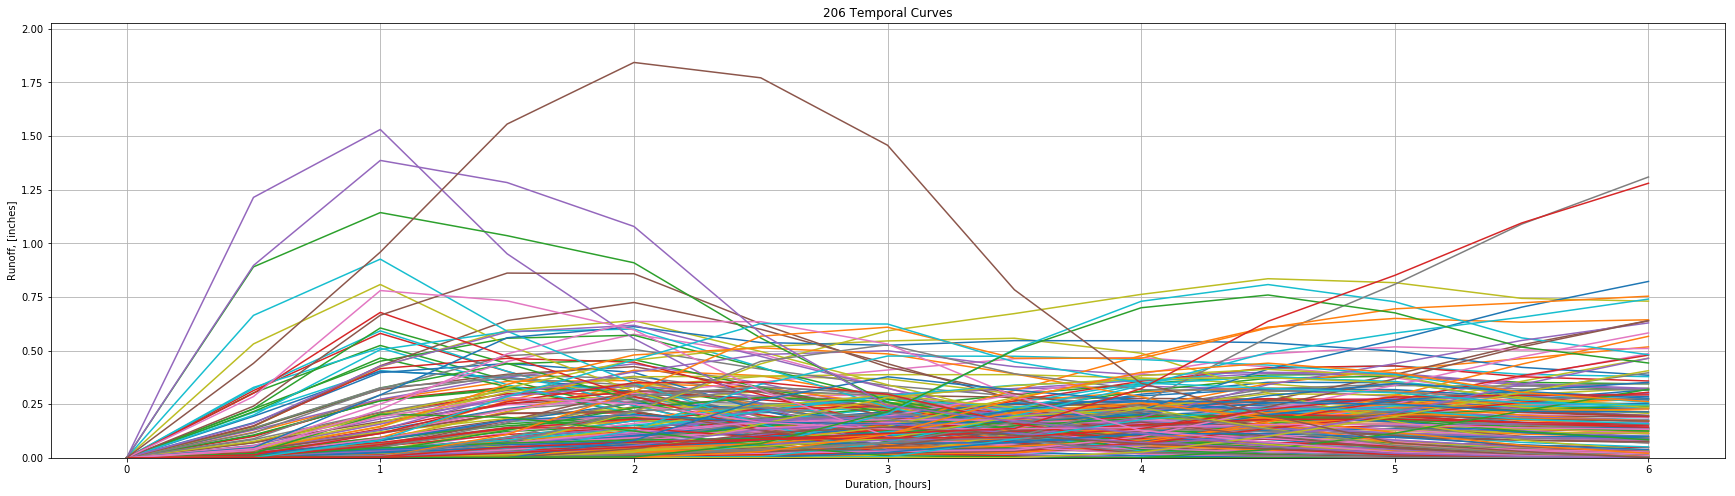

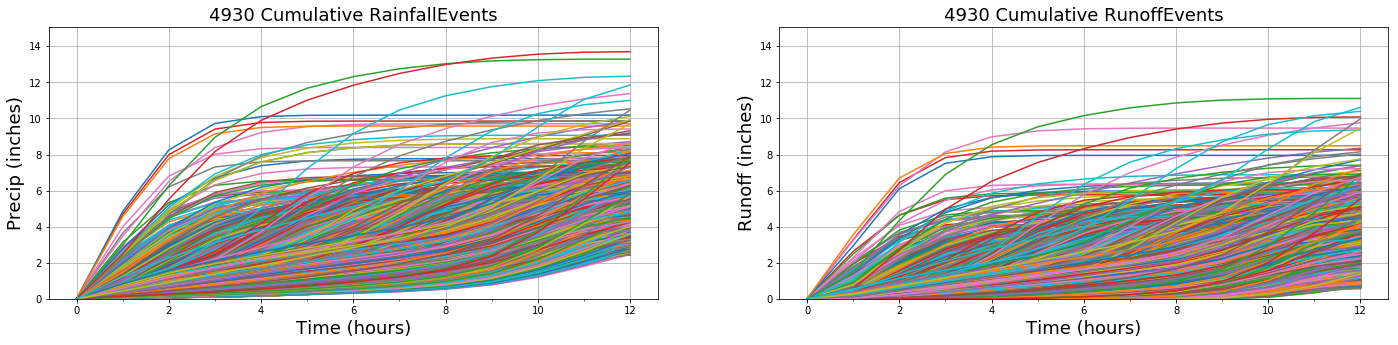

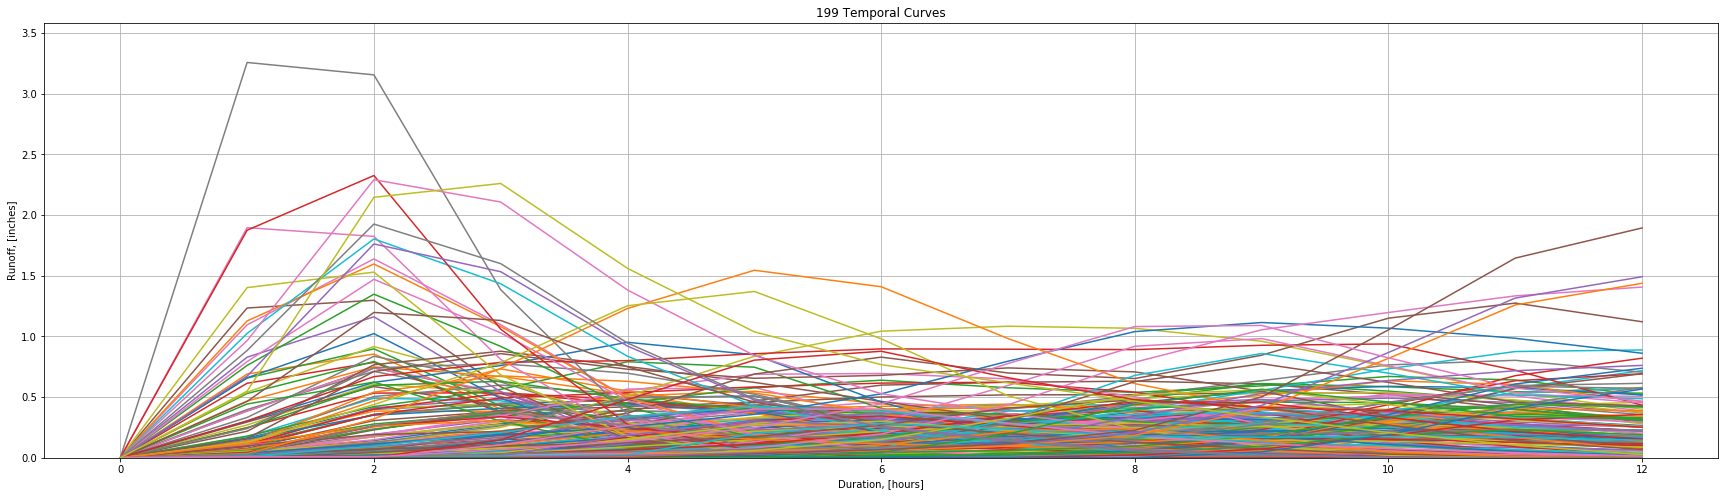

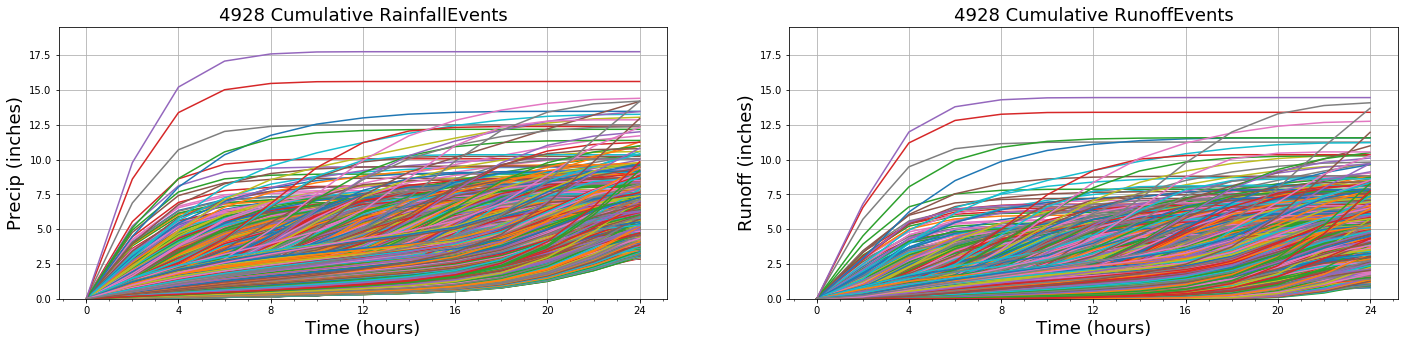

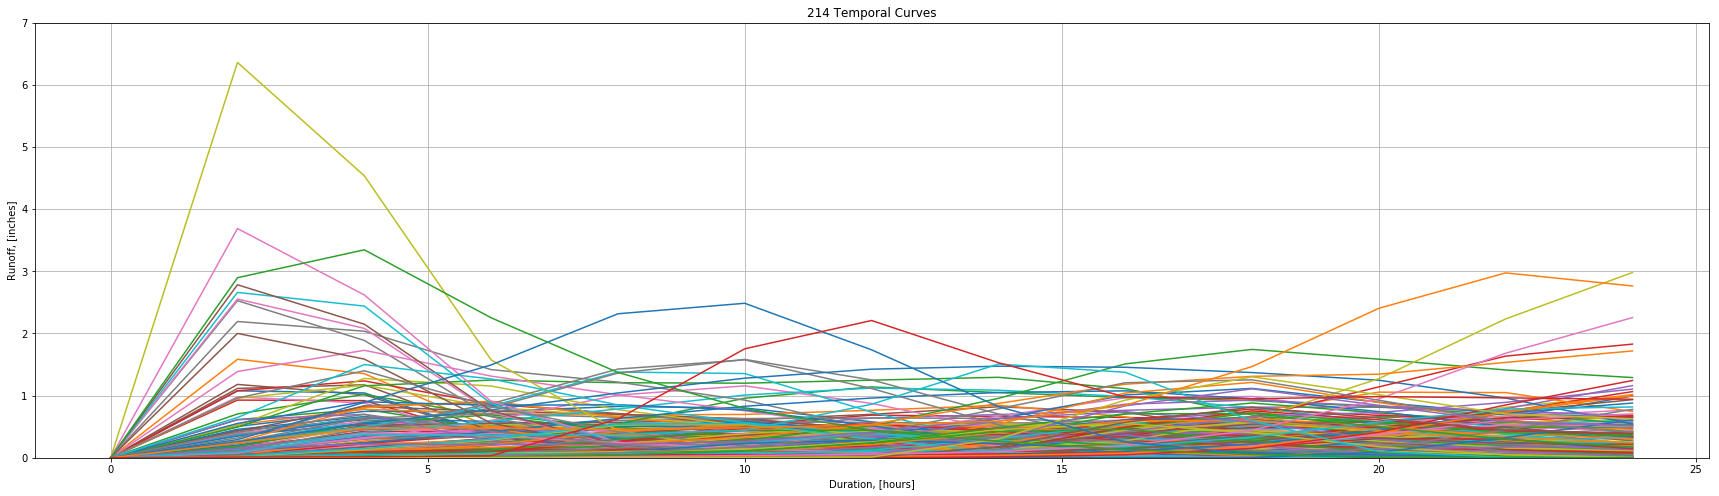

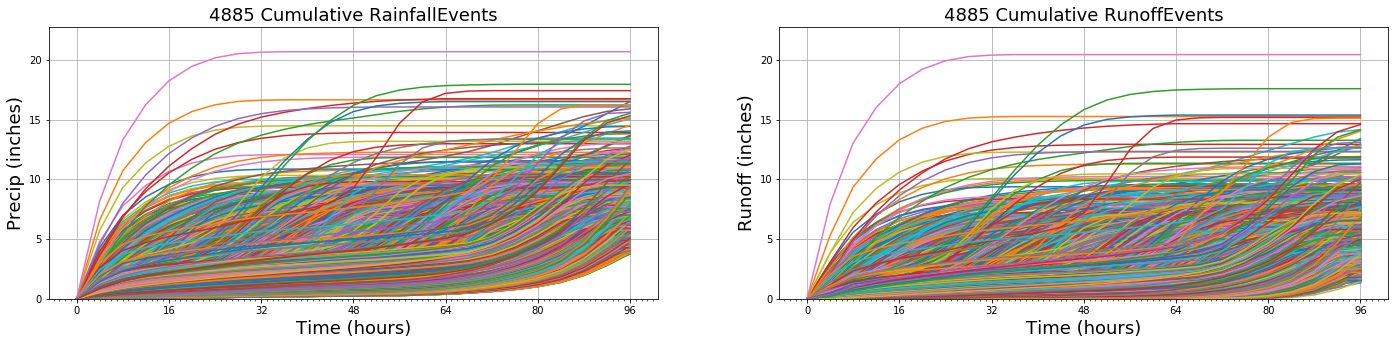

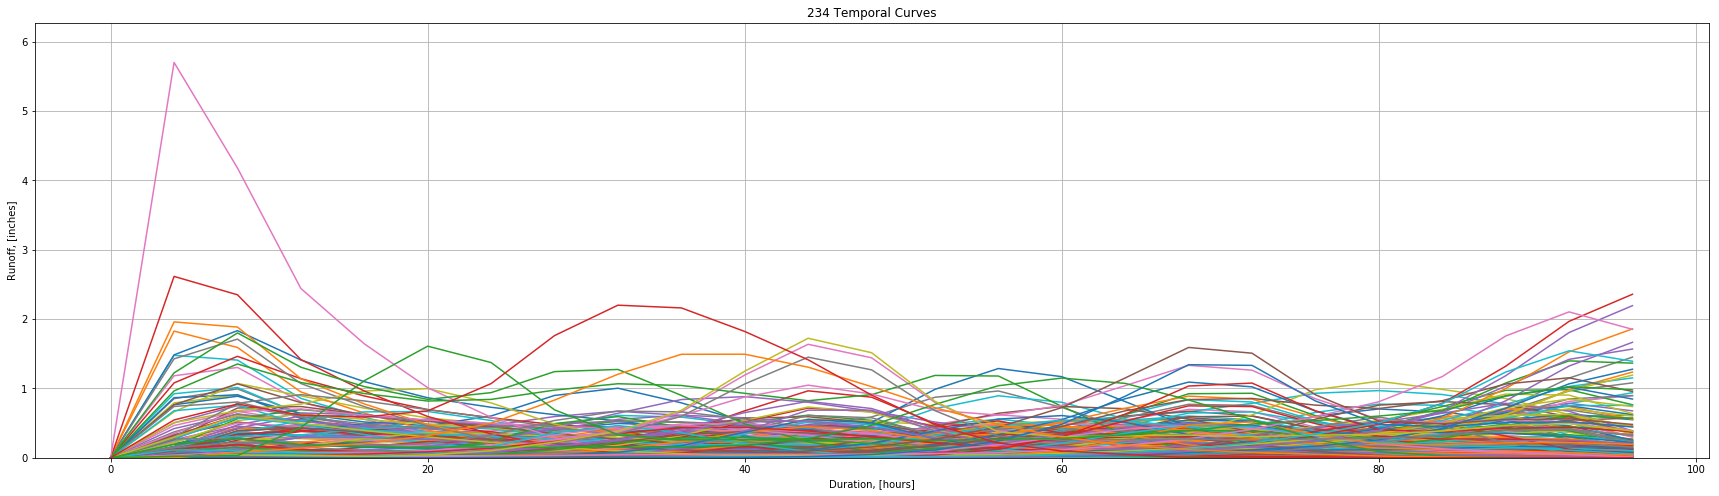

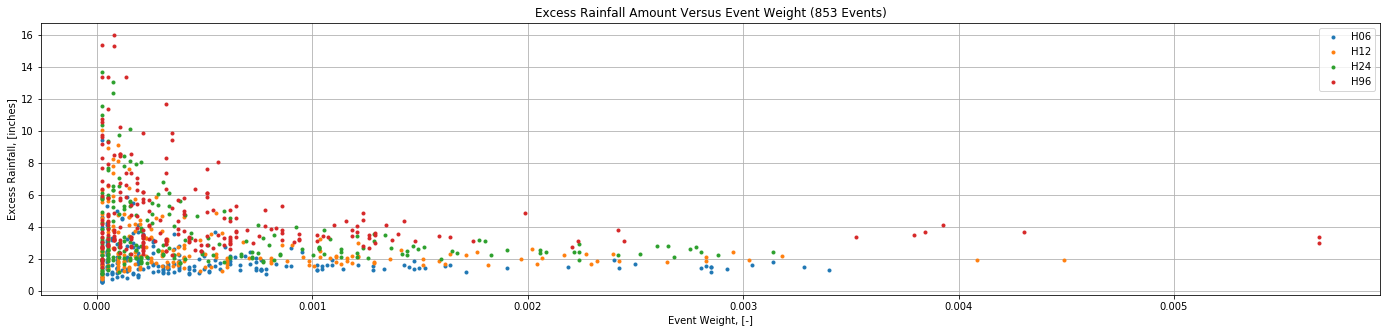

In [13]:
count = 1
d_plots = False
for distalBCN in distalBCNs:
    if (count/5).is_integer() or count == 1: 
        d_print = display_print
    else:
        d_print = False
    if count == len(distalBCNs):
        d_plots = display_plots
    else:
        d_plots = False
        
    CN = get_CN(pluvial_params_dir, distalBCN, d_print)
    
    arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, d_print)

    hydromet_distal.main(md, weights_dic, durations, mainBCN, CN, arc_data, Project_Area, Pluvial_Model, distalBCN, outputs_dir, 
                         time_idx_ordinate, run_dur_dic, pluvial_BC_units, adjust_CN_less24, remove_intermediates, d_print, d_plots, 
                         pad_forcing, uniform_pad, pad_num)  
    
    count+=1

---

## C. Run reEventsTable Notebook:
- Check if each distal domain has stormwater infrastructure.
- If it does, run the notebook.

In [14]:
count = 1
for distalBCN in distalBCNs:
    if (count/5).is_integer() or count == 1: 
        d_print = display_print
    else:
        d_print = False
    if count == len(distalBCNs):
        d_plots = display_plots
    else:
        d_plots = False
        
    run_reduced = checkif_SWinfra(pluvial_params_dir, distalBCN, d_print)
    
    if run_reduced == 'YES':
        reEventsTable = str(notebook_dir/'reEventsTable_{0}_{1}_{2}.ipynb'.format(Project_Area, Pluvial_Model, distalBCN))
        
        nb_parameters = {'Project_Area': Project_Area, 'Pluvial_Model': Pluvial_Model, 'BCN': distalBCN, 'pluvial_params_dir': str(pluvial_params_dir), 
                         'rate_column': rate_column, 'capacity_column': capacity_column, 'efficiency_column': efficiency_column, 'outputs_dir': str(outputs_dir),
                         'display_plots': display_plots, 'display_print': display_print, 'pad_forcing': pad_forcing, 'uniform_pad': uniform_pad, 'pad_num': pad_num}
        
        pm.execute_notebook('reEventsTable.ipynb', reEventsTable, parameters = nb_parameters);
        
        ! jupyter nbconvert $reEventsTable --log-level WARN
        
    count+=1    

Is there stormwater infrastructure? -> YES


---

## D. Save a Copy of this Notebook:

### File save this notebook and then run:

In [15]:
orig_nb = 'distalEventsTable'
new_nb = '{0}_{1}_{2}_{3}.ipynb'.format(orig_nb, Project_Area, Pluvial_Model, mainBCN)
new_nb_path = str(notebook_dir/new_nb)

shutil.copy(pl.Path(os.getcwd())/'{0}.ipynb'.format(orig_nb), new_nb_path)

! jupyter nbconvert $new_nb_path --log-level WARN

if display_print: print('Runtime: {} Minutes'.format(round(time.time()-start_time)/60, 3))         

Runtime: 4.633333333333334 Minutes


---

# End